In [2]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import os
import matplotlib.pyplot as plt
import random

from torch.utils.data import DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# MNIST 데이터셋
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

cuda


In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE,self).__init__()

        # 인코더
        self.fc1 = nn.Linear(28 * 28, 400)

        # 잠재 변수의 평균과 log 분산
        self.fc21 = nn.Linear(400, latent_dim) # 평균
        self.fc22 = nn.Linear(400, latent_dim) # 분산

        # 디코더
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        # 표준편차 계산 logvar는 log(sigma^2) -->  std = exp((1/2) * log(sigma^2)) = sigma
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)) # 출력값을 0~1 로 처리

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [5]:
# 손실함수
# VAE의 손실 함수는 재구성 손실(BCE)과 KL 발산(KLD) 손실의 합으로 구성됩니다.
# beta 값은 KL 손실의 가중치를 조절합니다.
beta = 1.0
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1,28*28), reduction='sum')
    KLD = -0.5 * torch.sum(-mu.pow(2) - logvar.exp() + logvar + 1 )
    return BCE + beta * KLD

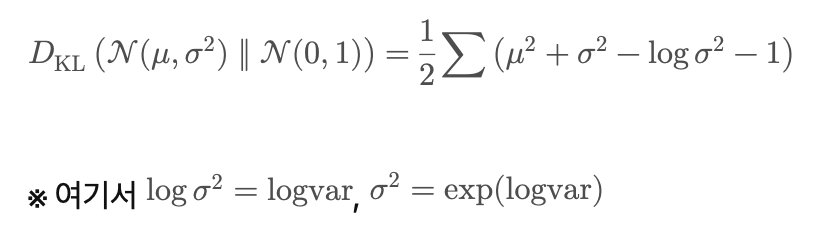

In [6]:
latent_dim = 2
model = VAE(latent_dim=latent_dim).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in trainloader:
        data = data.to(device)
        opt.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        opt.step()

        train_loss += loss.item()
    print(f"{epoch+1} / {num_epochs}  Loss : {train_loss / len(trainloader.dataset)}")

1 / 100  Loss : 203.29318131510416
2 / 100  Loss : 174.85178776041667
3 / 100  Loss : 167.81392024739583
4 / 100  Loss : 164.103933203125
5 / 100  Loss : 161.7452470703125
6 / 100  Loss : 160.1218291015625
7 / 100  Loss : 158.82836157226564
8 / 100  Loss : 157.85160966796875
9 / 100  Loss : 157.01693771158855
10 / 100  Loss : 156.3455630533854
11 / 100  Loss : 155.64377633463542
12 / 100  Loss : 155.09171069335937
13 / 100  Loss : 154.6505871907552
14 / 100  Loss : 154.19110740559896
15 / 100  Loss : 153.75346131184895
16 / 100  Loss : 153.3503051920573
17 / 100  Loss : 152.9804615559896
18 / 100  Loss : 152.6546398111979
19 / 100  Loss : 152.33956181640625
20 / 100  Loss : 152.03806897786458
21 / 100  Loss : 151.74091930338543
22 / 100  Loss : 151.48135857747397
23 / 100  Loss : 151.16269625651043
24 / 100  Loss : 150.91950498046876
25 / 100  Loss : 150.7701853190104
26 / 100  Loss : 150.48632542317708
27 / 100  Loss : 150.26108111979167
28 / 100  Loss : 150.0715705078125
29 / 100  Lo

In [7]:
# 잠재 공간 시각화
model.eval()
all_z = [] # 모든 잠재변수 저장 리스트
all_labels = []

with torch.no_grad():
    testset = torchvision.datasets.MNIST(
        root = './data',
        train = False,
        download = True,
        transform=transform
    )
    testloader = DataLoader(testset, batch_size=64, shuffle=False)

    for data, labels in testloader:
        data = data.to(device)
        mu, logvar = model.encode(data.view(-1, 28*28))
        z = model.reparameterize(mu, logvar)
        z = z.cpu().numpy()

        all_z.append(z)
        all_labels.append(labels)

    all_z = np.concatenate(all_z)
    all_labels = np.concatenate(all_labels)



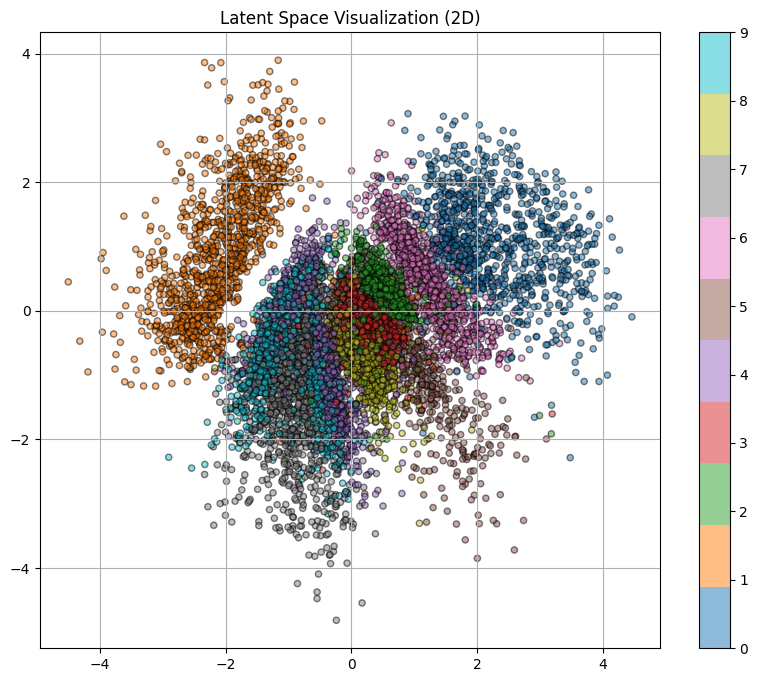

In [8]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(all_z[:,0], all_z[:,1], c=all_labels, cmap='tab10',
                      alpha = 0.5, edgecolor='k', s=20)
plt.colorbar(scatter, ticks=range(10))
plt.title('Latent Space Visualization (2D)')
plt.grid(True)
plt.show()

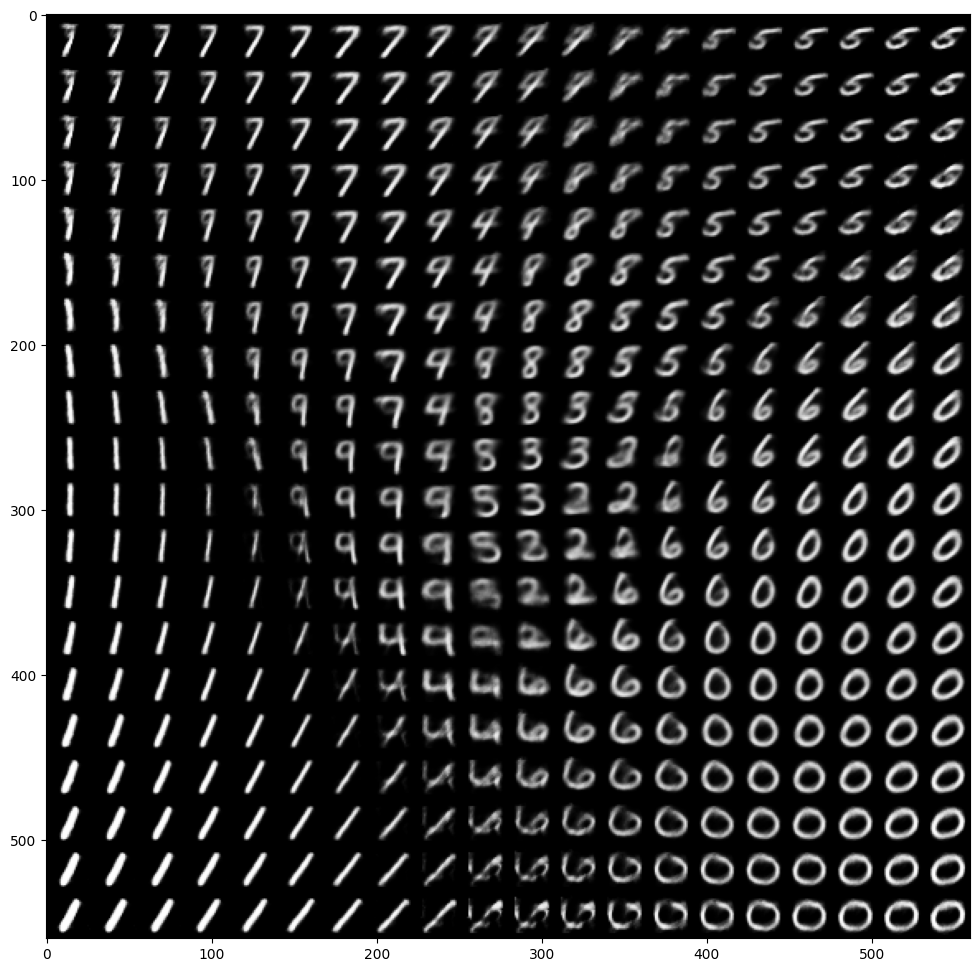

In [9]:
with torch.no_grad():
    grid_x = np.linspace(-3, 3, 20)
    grid_y = np.linspace(-3, 3, 20)
    figure = np.zeros((28*20, 28*20))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = torch.Tensor([[xi, yi]]).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded.view(28,28).cpu().numpy()
            figure[i*28:(i+1)*28 , j*28:(j+1)*28] = digit

    plt.figure(figsize=(12,12))
    plt.imshow(figure, cmap='gray')
    plt.show()

In [10]:
### 잠재 공간 차원 확장: 128D로 재학습 ###
# 잠재 공간의 차원을 128로 확장하여 학습하면 재구성 품질이 개선될 수 있습니다.
latent_dim = 128
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

print("128D 잠재 공간으로 학습 시작...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader.dataset)}')


128D 잠재 공간으로 학습 시작...
Epoch 1, Loss: 195.4360390625
Epoch 2, Loss: 144.31551814778646
Epoch 3, Loss: 131.59014231770834
Epoch 4, Loss: 123.42469576822917
Epoch 5, Loss: 117.81383846028646
Epoch 6, Loss: 114.3183411295573
Epoch 7, Loss: 112.05332096354167
Epoch 8, Loss: 110.50475094401041
Epoch 9, Loss: 109.41053723958333
Epoch 10, Loss: 108.46171990559895
Epoch 11, Loss: 107.84056695963541
Epoch 12, Loss: 107.26197005208333
Epoch 13, Loss: 106.79158037109374
Epoch 14, Loss: 106.40285598958333
Epoch 15, Loss: 106.04124308268229
Epoch 16, Loss: 105.76776935221355
Epoch 17, Loss: 105.56682044270833
Epoch 18, Loss: 105.30930188802083
Epoch 19, Loss: 105.06310183919271
Epoch 20, Loss: 104.88600130208333
Epoch 21, Loss: 104.75778569335938
Epoch 22, Loss: 104.5985493326823
Epoch 23, Loss: 104.41795685221354
Epoch 24, Loss: 104.25623763020833
Epoch 25, Loss: 104.13634739583334
Epoch 26, Loss: 104.02331513671875
Epoch 27, Loss: 103.95019716796875
Epoch 28, Loss: 103.75920201822916
Epoch 29, Los

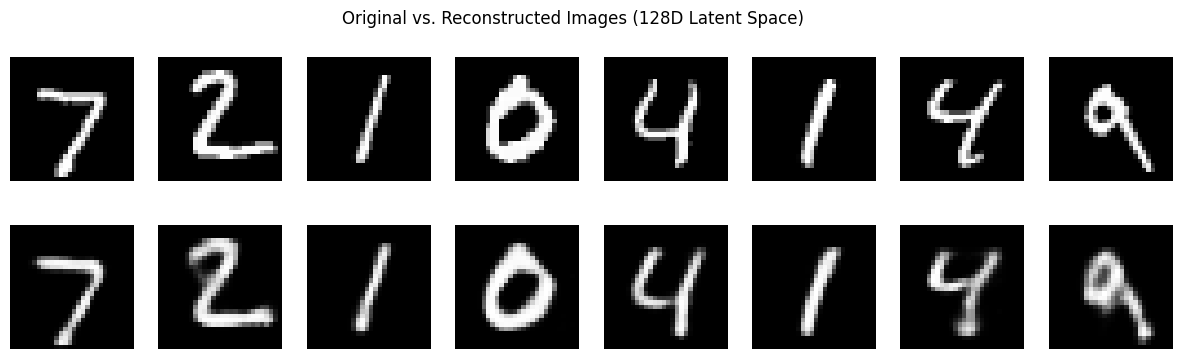

In [11]:
### 128D 잠재 공간 재구성 결과 시각화 ###
model.eval()
with torch.no_grad():
    # 테스트 데이터셋에서 일부 데이터를 선택하여 재구성 결과 확인
    data, _ = next(iter(testloader))
    data = data.to(device)
    recon, _, _ = model(data)
    recon = recon.view(-1, 1, 28, 28).cpu().numpy()

    # 원본 이미지와 재구성 이미지를 나란히 비교하여 시각화
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        # 첫 번째 행: 원본 이미지
        axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        # 두 번째 행: 재구성된 이미지
        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Original vs. Reconstructed Images (128D Latent Space)")
    plt.show()